<a href="https://colab.research.google.com/github/Matej1011/IOU-eval/blob/main/MedSAM_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r sample_data/

In [ ]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git
!git clone https://github.com/bowang-lab/MedSAM.git

!mkdir -p /content/data

from google.colab import drive
drive.mount('/content/drive')

# download model and data
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

import nibabel as nib

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [ ]:
import csv
from time import process_time

def read_bb_data(row, data):
    line = 0
    row = int(row)
    with open('/content/drive/MyDrive/SR/bb_info.csv', mode='r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for r in reader:
            if line != row:
                line+=1
            else:
                return r[data]
def get_csv_index(patient_id):
  with open('/content/drive/MyDrive/SR/bb_index_info.csv', mode='r', newline='') as csvfile:
    read = csv.DictReader(csvfile)
    for r in read:
      if r["Patient id #"] == patient_id:
        return r['csv_index']


In [ ]:
csv_index = 1000
print(read_bb_data(csv_index, "Patient id #"))

11988


In [ ]:
print(get_csv_index('3168'))

21557


In [ ]:
directory_list = []
for filename in os.listdir(directory):
  directory_list.append(filename)
for name in directory_list:
  print(name)

CT_Abd_1.2.826.0.1.3680043.12833.npz
CT_Abd_1.2.826.0.1.3680043.12292.npz
CT_Abd_1.2.826.0.1.3680043.12281.npz
CT_Abd_1.2.826.0.1.3680043.11988.npz
CT_Abd_1.2.826.0.1.3680043.10921.npz
CT_Abd_1.2.826.0.1.3680043.11827.npz
CT_Abd_1.2.826.0.1.3680043.10633.npz
CT_Abd_1.2.826.0.1.3680043.16092.npz
CT_Abd_1.2.826.0.1.3680043.1573.npz
CT_Abd_1.2.826.0.1.3680043.1542.npz
CT_Abd_1.2.826.0.1.3680043.1480.npz
CT_Abd_1.2.826.0.1.3680043.15206.npz
CT_Abd_1.2.826.0.1.3680043.14267.npz
CT_Abd_1.2.826.0.1.3680043.1363.npz
CT_Abd_1.2.826.0.1.3680043.18906.npz
CT_Abd_1.2.826.0.1.3680043.1868.npz
CT_Abd_1.2.826.0.1.3680043.16919.npz
CT_Abd_1.2.826.0.1.3680043.18480.npz
CT_Abd_1.2.826.0.1.3680043.17960.npz
CT_Abd_1.2.826.0.1.3680043.17481.npz
CT_Abd_1.2.826.0.1.3680043.20647.npz
CT_Abd_1.2.826.0.1.3680043.20120.npz
CT_Abd_1.2.826.0.1.3680043.18935.npz
CT_Abd_1.2.826.0.1.3680043.19388.npz
CT_Abd_1.2.826.0.1.3680043.19021.npz
CT_Abd_1.2.826.0.1.3680043.18968.npz
CT_Abd_1.2.826.0.1.3680043.19333.npz
CT_Abd

CAREFUL WITH WHAT'S BEING SEGMENTED IN CURRENT VERSION

In [ ]:
random_testing_integer = 0
patient = 0

#%% load model
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

#%% load image

directory = '/content/drive/MyDrive/SR/preprocessed_patient_npz_files'
csv_index = 0

for filename in os.listdir(directory):
  #conditional statement used so that segmentation can be continued only for certain patients/after certain parts and doesn't start from the beginning each time
  if patient > 85:
    print("Patient ", patient)

    masks = []

    data = np.load(os.path.join(directory, filename))

    patient_id = ''
    if filename[31].isdigit():
      patient_id = filename[27:32:1]
    elif filename[30].isdigit():
      patient_id = filename[27:31:1]
    else:
      patient_id = filename[27:30:1]

    csv_index = int(get_csv_index(patient_id))
    print("Patient id: ", read_bb_data(csv_index, 'Patient id #'))

    slices = len(data['imgs'])

    for i in range(slices):
      img_np = data['imgs'][i]

      if len(img_np.shape) == 2:
          img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
      else:
          img_3c = img_np
      H, W, _ = img_3c.shape

      #%% image preprocessing and model inference

      img_1024 = img_3c
      img_1024 = (img_1024 - img_1024.min()) / np.clip(
          img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
      )  # normalize to [0, 1], (H, W, 3)
      # convert the shape to (3, H, W)
      img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

      min_x = int(read_bb_data(csv_index, 'min_x')) * 2
      min_y = abs(int(read_bb_data(csv_index, 'max_y'))- 512) * 2
      max_x = int(read_bb_data(csv_index, 'max_x')) * 2
      max_y = abs(int(read_bb_data(csv_index, 'min_y'))- 512) * 2

      box_np = np.array([[min_x, min_y, max_x, max_y]])
      # transfer box_np t0 1024x1024 scale
      box_1024 = box_np / np.array([W, H, W, H]) * 1024
      with torch.no_grad():
          image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

      medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

      masks.append(medsam_seg)

      csv_index += 1

    stacked_masks = np.stack(masks, axis=0)
    np.savez('/content/data/'+ read_bb_data(csv_index, 'Patient id #') + '.npz', masks=stacked_masks)

  patient += 1

Filename:  CT_Abd_1.2.826.0.1.3680043.29425.npz idx:  0
Filename:  CT_Abd_1.2.826.0.1.3680043.30067.npz idx:  1
Filename:  CT_Abd_1.2.826.0.1.3680043.30487.npz idx:  2
Filename:  CT_Abd_1.2.826.0.1.3680043.30524.npz idx:  3
Filename:  CT_Abd_1.2.826.0.1.3680043.30565.npz idx:  4
Filename:  CT_Abd_1.2.826.0.1.3680043.30640.npz idx:  5
Filename:  CT_Abd_1.2.826.0.1.3680043.31077.npz idx:  6
Filename:  CT_Abd_1.2.826.0.1.3680043.3168.npz idx:  7
Filename:  CT_Abd_1.2.826.0.1.3680043.32071.npz idx:  8
Filename:  CT_Abd_1.2.826.0.1.3680043.780.npz idx:  9
Filename:  CT_Abd_1.2.826.0.1.3680043.32658.npz idx:  10
Filename:  CT_Abd_1.2.826.0.1.3680043.5782.npz idx:  11
Filename:  CT_Abd_1.2.826.0.1.3680043.4769.npz idx:  12
Filename:  CT_Abd_1.2.826.0.1.3680043.32436.npz idx:  13
Filename:  CT_Abd_1.2.826.0.1.3680043.32590.npz idx:  14
Filename:  CT_Abd_1.2.826.0.1.3680043.32280.npz idx:  15
Filename:  CT_Abd_1.2.826.0.1.3680043.3376.npz idx:  16
Filename:  CT_Abd_1.2.826.0.1.3680043.32370.npz

In [ ]:
!unzip /content/npz_masks.zip -d /content/data

Archive:  /content/10633_processed_30.zip
   creating: /content/data/content/data/
  inflating: /content/data/content/data/10633_S9.npy  
  inflating: /content/data/content/data/10633_S22.npy  
  inflating: /content/data/content/data/10633_S25.npy  
  inflating: /content/data/content/data/10633_S18.npy  
  inflating: /content/data/content/data/10633_S17.npy  
  inflating: /content/data/content/data/10633_S8.npy  
  inflating: /content/data/content/data/10633_S27.npy  
  inflating: /content/data/content/data/10633_S0.npy  
  inflating: /content/data/content/data/10633_S23.npy  
  inflating: /content/data/content/data/10633_S19.npy  
  inflating: /content/data/content/data/10633_S12.npy  
  inflating: /content/data/content/data/10633_S2.npy  
  inflating: /content/data/content/data/10633_S28.npy  
  inflating: /content/data/content/data/10633_S20.npy  
  inflating: /content/data/content/data/10633_S29.npy  
  inflating: /content/data/content/data/10633_S7.npy  
  inflating: /content/data

In [ ]:
!zip -r data.zip /content/data/
from google.colab import files

files.download('data.zip')

  adding: content/data/ (stored 0%)
  adding: content/data/5002.npz (deflated 100%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Don't need to run the code below right now. It is slightly edited but more original code. Above is the code I put together and automated.

I'm changing the below code.
Originally: img_np = io.imread('img_demo.png')
changed: img_np = np.load(/content/npz file/CT_Abd_1.2.826.0.1.3680043.10633-010.npy)

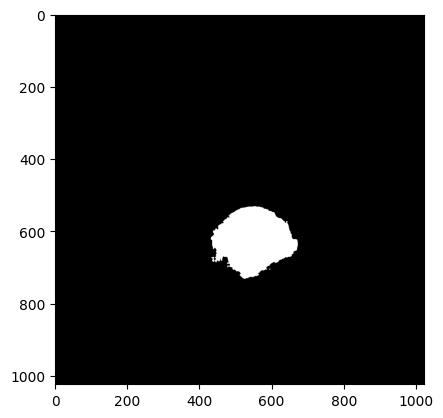

In [ ]:
npz_file = np.load('/content/data/30487.npz')
data = npz_file['masks'][132]
plt.imshow(data, cmap='gray')
plt.show()

In [ ]:
data = np.load('/content/CT_Abd_1.2.826.0.1.3680043.10633.npz')
print(data.files)

['imgs', 'gts', 'spacing']


In [ ]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

data = np.load('/content/drive/MyDrive/SR/preprocessed_patient_npz_files/CT_Abd_1.2.826.0.1.3680043.30487.npz')
img_np = data['imgs'][131]


if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [ ]:
#%% image preprocessing and model inference
#img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)


index = int(get_csv_index('30487')) + 131
print(index)
min_x = int(read_bb_data(index, 'min_x')) * 2
min_y = abs(int(read_bb_data(index, 'max_y'))- 512) * 2
max_x = int(read_bb_data(index, 'max_x')) * 2
max_y = abs(int(read_bb_data(index, 'min_y'))- 512) * 2

box_np = np.array([[min_x, min_y, max_x, max_y]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

mask = []
mask.append(medsam_seg)
stacked_mask = np.stack(mask, axis=0)
np.savez('/content/data/test' + '.npz', mask=stacked_mask)

19963


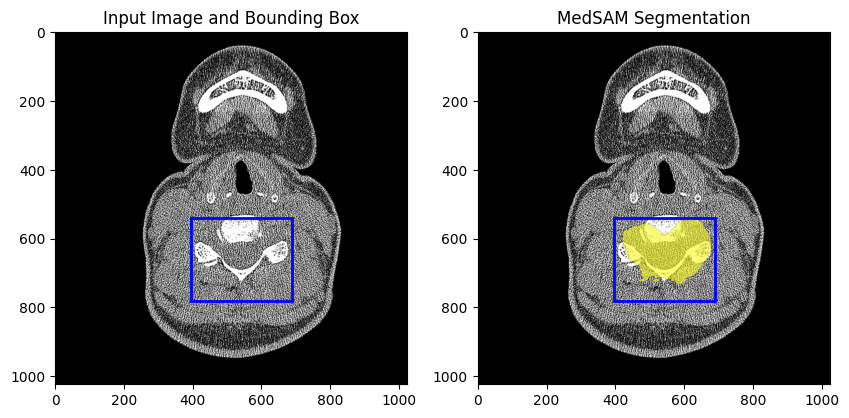

In [ ]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

np.save('medsam_seg.npy', medsam_seg)

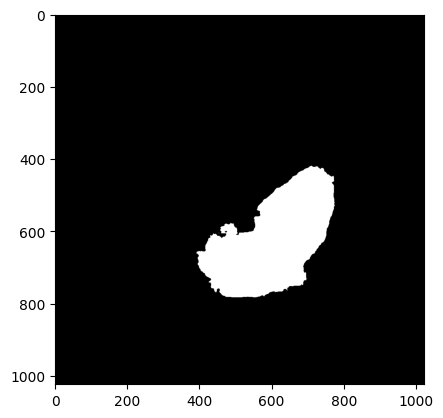

TypeError: Image data of dtype <U4 cannot be converted to float

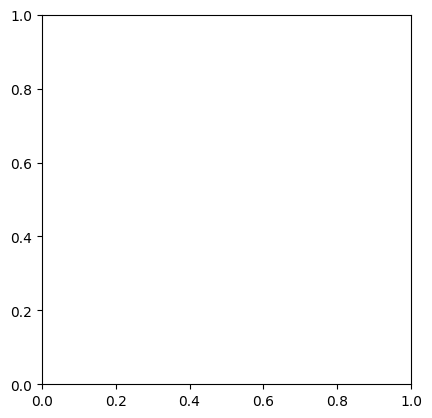

In [ ]:
data2 = np.load('medsam_seg.npy')
plt.imshow(data2, cmap='gray')
plt.show()